# **Setting** #

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

%matplotlib inline

# Setup feedback system
from learntools.core import binder
binder.bind(globals())
from learntools.time_series.ex3 import *

 # Allows the use of display() for DataFrames
# from IPython.core.interactiveshell import InteractiveShell 
# InteractiveShell.ast_node_interactivity = "all"


# Setup notebook
from pathlib import Path
from IPython.display import display

from learntools.time_series.style import *  # plot style settings
from learntools.time_series.utils import plot_periodogram, seasonal_plot


import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LinearRegression
from statsmodels.tsa.deterministic import CalendarFourier, DeterministicProcess


# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

        
        
# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session


/kaggle/input/store-sales-time-series-forecasting/oil.csv
/kaggle/input/store-sales-time-series-forecasting/sample_submission.csv
/kaggle/input/store-sales-time-series-forecasting/holidays_events.csv
/kaggle/input/store-sales-time-series-forecasting/stores.csv
/kaggle/input/store-sales-time-series-forecasting/train.csv
/kaggle/input/store-sales-time-series-forecasting/test.csv
/kaggle/input/store-sales-time-series-forecasting/transactions.csv


# **Get Data** #

In [2]:
# Paths
comp_dir = Path('../input/store-sales-time-series-forecasting')

# Get datas
holidays_events = pd.read_csv(
    comp_dir / "holidays_events.csv",
    dtype={
        'type': 'category',
        'locale': 'category',
        'locale_name': 'category',
        'description': 'category',
        'transferred': 'bool',
    },
    parse_dates=['date'],
    infer_datetime_format=True,
)
holidays_events = holidays_events.set_index('date').to_period('D')

store_sales = pd.read_csv(
    comp_dir / 'train.csv',
    usecols=['store_nbr', 'family','onpromotion', 'date', 'sales'],
    dtype={
        'store_nbr': 'category',
        'family': 'category',
        'sales': 'float32',
        'onpromotion': 'uint32',
    },
    parse_dates=['date'],
    infer_datetime_format=True,
)

oil = pd.read_csv(
    comp_dir / 'oil.csv',
    usecols = ['date', 'dcoilwtico'],
    dtype={'dcoilwtico': 'float32'    },
    parse_dates=['date'],
    infer_datetime_format=True,
)

holidays = (
    holidays_events
    .query("locale in ['National', 'Regional']")
    .loc['2017':'2017-08-15', ['description']]
    .assign(description=lambda x: x.description.cat.remove_unused_categories()) # assign new columns
)

df_test = pd.read_csv(
    comp_dir / 'test.csv',
    dtype={
        'store_nbr': 'category',
        'family': 'category',
        'onpromotion': 'uint32',
    },
    parse_dates=['date'],
    infer_datetime_format=True,
)
# Rearray to period

transactions =  pd.read_csv( comp_dir / 'transactions.csv',
                            parse_dates = ['date'], 
                            infer_datetime_format = True, 
                            )

# oil['date'] = oil.date.dt.to_period('D')
oil = oil.set_index(['date']).sort_index()
oil=oil.squeeze()

store_sales['date'] = store_sales.date.dt.to_period('D')
store_sales = store_sales.set_index(['store_nbr', 'family', 'date']).sort_index()



In [3]:
 # transactions per store
transactions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 83488 entries, 0 to 83487
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   date          83488 non-null  datetime64[ns]
 1   store_nbr     83488 non-null  int64         
 2   transactions  83488 non-null  int64         
dtypes: datetime64[ns](1), int64(2)
memory usage: 1.9 MB


#  **Exploratory Data Analysis** #

,sales,onpromotion
date,,
2017-01-01,6.780303,0.095398
2017-01-02,786.928406,6.628507
2017-01-03,619.740234,7.803591
2017-01-04,555.608032,12.860831
2017-01-05,436.375397,4.797980


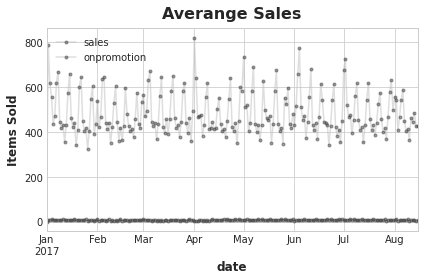

In [4]:

# average sales 
average_sales = (
    store_sales
    .groupby('date').mean()
    .squeeze()
    .loc['2017']
)

display(average_sales.head())
ax = average_sales.plot(**plot_params, alpha = 0.5,  title='Averange Sales', ylabel='Items Sold')
ax.legend();

In [5]:
holidays.head()

,description
date,
2017-01-01,Primer dia del ano
2017-01-02,Traslado Primer dia del ano
2017-02-27,Carnaval
2017-02-28,Carnaval
2017-04-01,Provincializacion de Cotopaxi


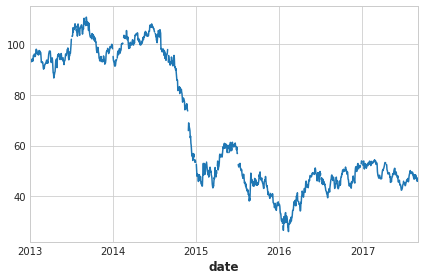

In [6]:
oil.plot()
plt.show()

In [7]:
print(oil.name) 

dcoilwtico


# **Model with Oil** #


In [8]:
y = store_sales.unstack(['store_nbr', 'family']).loc["2017"] 


# Create training data
fourier = CalendarFourier(freq='M', order=4)
dp = DeterministicProcess(
    index=y.index,
    constant=True,
    order=1,
    seasonal=True,
    additional_terms=[fourier],
    drop=True,
)
X = dp.in_sample()
X['NewYear'] = (X.index.dayofyear == 1)
X_holidays = pd.get_dummies(holidays) # add columns on Holidays, more featured, way matricial

display(X_holidays.head())
X = X.join( oil.rename('Oil') , on='date').fillna(0.0)

from sklearn.preprocessing import OneHotEncoder
 


X2 = X.join(X_holidays, on='date').fillna(0.0)

missingValueCount = X2.isnull().sum()
print('Num_null: ' , missingValueCount.sum() )
X2 = X2.dropna()
X2 = X2.fillna(0)

display(X2.info())


,description_Batalla de Pichincha,description_Carnaval,description_Dia de la Madre,description_Dia de la Madre-1,description_Dia del Trabajo,description_Primer Grito de Independencia,description_Primer dia del ano,description_Provincializacion de Cotopaxi,description_Provincializacion de Imbabura,description_Traslado Batalla de Pichincha,description_Traslado Primer Grito de Independencia,description_Traslado Primer dia del ano,description_Viernes Santo
date,,,,,,,,,,,,,
2017-01-01,0,0,0,0,0,0,1,0,0,0,0,0,0
2017-01-02,0,0,0,0,0,0,0,0,0,0,0,1,0
2017-02-27,0,1,0,0,0,0,0,0,0,0,0,0,0
2017-02-28,0,1,0,0,0,0,0,0,0,0,0,0,0
2017-04-01,0,0,0,0,0,0,0,1,0,0,0,0,0


Num_null:  0
<class 'pandas.core.frame.DataFrame'>
PeriodIndex: 227 entries, 2017-01-01 to 2017-08-15
Freq: D
Data columns (total 31 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   const                                               227 non-null    float64
 1   trend                                               227 non-null    float64
 2   s(2,7)                                              227 non-null    float64
 3   s(3,7)                                              227 non-null    float64
 4   s(4,7)                                              227 non-null    float64
 5   s(5,7)                                              227 non-null    float64
 6   s(6,7)                                              227 non-null    float64
 7   s(7,7)                                              227 non-null    float64
 8   sin(1,freq=M)                             

None

In [9]:

model = LinearRegression(fit_intercept=False)
model.fit(X2, y)
y_pred = pd.DataFrame(model.predict(X2), index=X2.index, columns=y.columns)

y_pred.info()

<class 'pandas.core.frame.DataFrame'>
PeriodIndex: 227 entries, 2017-01-01 to 2017-08-15
Freq: D
Columns: 3564 entries, ('sales', '1', 'AUTOMOTIVE') to ('onpromotion', '9', 'SEAFOOD')
dtypes: float64(3564)
memory usage: 6.2 MB


We see a low in the price oil, at the end of 2014.

### Missing Values ###

In [10]:
df_test = pd.read_csv(
    comp_dir / 'test.csv',
    dtype={
        'store_nbr': 'category',
        'family': 'category',
        'onpromotion': 'uint32',
    },
    parse_dates=['date'],
    infer_datetime_format=True,
)

df_test['date'] = df_test.date.dt.to_period('D')
df_test = df_test.set_index(['store_nbr', 'family', 'date']).sort_index()

# Create features for test set
X_test = dp.out_of_sample(steps=16)
X_test.index.name = 'date'
X_test['NewYear'] = (X_test.index.dayofyear == 1)
X_test = X_test.join( oil.rename('Oil') , on='date').fillna(0.0)
X_test = X_test.join(X_holidays, on='date').fillna(0.0)


X_test.info()

<class 'pandas.core.frame.DataFrame'>
PeriodIndex: 16 entries, 2017-08-16 to 2017-08-31
Freq: D
Data columns (total 31 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   const                                               16 non-null     float64
 1   trend                                               16 non-null     float64
 2   s(2,7)                                              16 non-null     float64
 3   s(3,7)                                              16 non-null     float64
 4   s(4,7)                                              16 non-null     float64
 5   s(5,7)                                              16 non-null     float64
 6   s(6,7)                                              16 non-null     float64
 7   s(7,7)                                              16 non-null     float64
 8   sin(1,freq=M)                                       16 n

In [11]:
y_submit = pd.DataFrame(model.predict(X_test), index=X_test.index, columns=y.columns)
y_submit.head()

sales                                                          \
store_nbr           1                                                           
family     AUTOMOTIVE BABY CARE    BEAUTY    BEVERAGES     BOOKS BREAD/BAKERY   
date                                                                            
2017-08-16   4.341548       0.0  3.452431  2395.177911  0.425745   390.551336   
2017-08-17   4.127794       0.0  2.563252  2045.710293  0.081730   336.073933   
2017-08-18   5.836514       0.0  2.568565  2408.384935  0.063010   367.850190   
2017-08-19   4.350567       0.0  3.001167  2422.493817 -0.236329   366.994103   
2017-08-20   1.729306       0.0  1.159444  1025.227708 -0.271743   122.567950   

                                                            ... onpromotion  \
store_nbr                                                   ...           9   
family     CELEBRATION    CLEANING       DAIRY        DELI  ...   MAGAZINES   
date                                                        ...               
2017-08-16   17.332727  814.175849  810.690309  138.790001  ...         0.0   
2017-08-17   20.314541  652.628073  663.738718  116.800825  ...         0.0   
2017-08-18   22.555630  736.839224  778.048344  178.898602  ...         0.0   
2017-08-19   12.634900  594.136059  730.848027  137.669231  ...         0.0   
2017-08-20    1.931911  204.858204  282.079091   58.538692  ...         0.0   

                                                                          \
store_nbr                                                                  
family          MEATS PERSONAL CARE PET SUPPLIES PLAYERS AND ELECTRONICS   
date                                                                       
2017-08-16   0.288287     13.338082     0.036032                0.105168   
2017-08-17  20.406772     12.241600    -0.023406                0.037320   
2017-08-18   0.462535     11.854817    -0.007709                0.090623   
2017-08-19   0.761641     11.935863     0.041451                0.036005   
2017-08-20   0.706361     12.133517     0.056176                0.187386   

                                                                            \
store_nbr                                                                    
family        POULTRY PREPARED FOODS    PRODUCE SCHOOL AND OFFICE SUPPLIES   
date                                                                         
2017-08-16  -0.211493       3.982727  10.833558                   2.259167   
2017-08-17  -0.163680      -1.055373   8.885126                   1.629003   
2017-08-18  20.198551      -0.060127   8.891111                   1.542577   
2017-08-19  -0.245516      -1.193101   8.936892                   1.799138   
2017-08-20  -0.246967      -1.250955   9.167326                   1.878502   

                      
store_nbr             
family       SEAFOOD  
date                  
2017-08-16  0.434602  
2017-08-17  0.295068  
2017-08-18  0.243447  
2017-08-19  3.380202  
2017-08-20  0.385910  

[5 rows x 3564 columns]

In [12]:
y_submit = pd.DataFrame(model.predict(X_test), index=X_test.index, columns=y.columns)
y_submit = y_submit.stack(['store_nbr', 'family'])
y_submit = y_submit.join(df_test.id).reindex(columns=['id', 'sales'])
y_submit.to_csv('submission.csv', index=False)

In [13]:
y_submit.head()

id        sales
date       store_nbr family                          
2017-08-16 1         AUTOMOTIVE  3000888     4.341548
                     BABY CARE   3000889     0.000000
                     BEAUTY      3000890     3.452431
                     BEVERAGES   3000891  2395.177911
                     BOOKS       3000892     0.425745

## Pre-Processing ##

### Selection only Giants or Dwarfs ###

## Balance ##

In [14]:
# dividir set 



# from sklearn.utils import resample
# dfGiantsDownSample = resample(dfGiants, 
  #                           replace = False, # sample without replacement
   #                          n_samples = num_of_dwarf,
   #                          random_state =1 
 #                            )
#dfDownSampled = pd.concat([dfGiantsDownSample , dfDwarfs] )

#dfBalanced= dfDownSampled.reset_index(drop=True)

# dataStar = dfBalanced.sample(frac=1).reset_index(drop=True) # shuffle
# dfCopyStar = dataStar.copy()

## Visualization ##

## Correlation Linear ##

## Data Cleaning ##

# **Data Processing** #

### Train and test Set ###

In [15]:
## Stratified ##
#from sklearn.model_selection import StratifiedShuffleSplit
#split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
#for train_index, test_index in split.split(data, data["variableStratificada"]):
#strat_train_set = housing.loc[train_index]
#strat_test_set = housing.loc[test_index]

#from  sklearn.impute import SimpleImputer
#imputer = SimpleImputer(strategy='median')

#from  sklearn.preprocessing import OneHotEncoder
#catEncoder = OneHotEncoder()

## numerical ##
#from  sklearn.pipeline import Pipeline
#from  sklearn.preprocessing import StandardScaler
#numerical_pipeline = Pipeline([('imputer', SimpleImputer(strategy="median")),('attribs_adder', CombinedAttributesAdder()),])
# new_variable_transformed_numerical = num_pipeline.fit_transform(varible_numerica)

## numerical and categorial ##
#from sklearn import ColumnTransformer
#numerical_attribs = list(numerical_columns)
#categorical_attribs = list(categorial_columns)
#full_pipeline = ColumnTransformer([("num", numerical_pipeline, numerical_attribs),("cat", OneHotEncoder(), categorical_attribs),])
#dataTotal_prepared = full_pipeline.fit_transform(dataTotal) 

## Target ## 

## Featuring Engineering ##

##  Pipeline and Featuring Scaling ##

 # **MODEL** # 

#### Models ####

In [16]:
### stratified CV ### see pag 136  Geron's book
#from sklearn.model_selection import StratifiedKFold
#from sklearn.base import clone
#skfolds = StratifiedKFold(n_splits=3, random_state=42)

# **Refinament** #

# **Deploy** #